In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset as TorchDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import Compose
import matplotlib.pyplot as plt

In [2]:
# Define Label class
from collections import namedtuple

Label = namedtuple('Label', [
    'name',        # The identifier of this label
    'id',          # An integer ID associated with this label
    'trainId',     # An integer ID for training
    'category',    # The name of the category
    'categoryId',  # The ID of the category
    'hasInstances',# Whether this label distinguishes between instances
    'ignoreInEval',# Whether to ignore pixels with this label during evaluation
    'greyscale'        # The color of this label in RGB
])

# Define your labels
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      20 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      20 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      20 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      20 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      20 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      20 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      20 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      20 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      20 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       20 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      20 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      20 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [3]:
image_train_dir = 'processed_images'
label_train_dir = 'processed_masks'
image_val_dir = 'processed_val_images'
label_val_dir = 'processed__val_masks'
test_dir = 'processed_test_images'

print("Images Directory:", os.listdir(image_train_dir))

print("Labels Directory:", os.listdir(label_train_dir))

print("Images Directory:", os.listdir(image_val_dir))

print("Labels Directory:", os.listdir(label_val_dir))

print("Test Directory:", os.listdir(test_dir))

Images Directory: ['image_0.png', 'image_1.png', 'image_10.png', 'image_100.png', 'image_101.png', 'image_102.png', 'image_103.png', 'image_104.png', 'image_105.png', 'image_106.png', 'image_107.png', 'image_108.png', 'image_109.png', 'image_11.png', 'image_110.png', 'image_111.png', 'image_112.png', 'image_113.png', 'image_114.png', 'image_115.png', 'image_116.png', 'image_117.png', 'image_118.png', 'image_119.png', 'image_12.png', 'image_120.png', 'image_121.png', 'image_122.png', 'image_123.png', 'image_124.png', 'image_125.png', 'image_126.png', 'image_127.png', 'image_128.png', 'image_129.png', 'image_13.png', 'image_130.png', 'image_131.png', 'image_132.png', 'image_133.png', 'image_134.png', 'image_135.png', 'image_136.png', 'image_137.png', 'image_138.png', 'image_139.png', 'image_14.png', 'image_140.png', 'image_141.png', 'image_142.png', 'image_143.png', 'image_144.png', 'image_145.png', 'image_146.png', 'image_147.png', 'image_148.png', 'image_149.png', 'image_15.png', 'imag

In [4]:
# Function to create DataFrame
def create_dataframe(images_dir, labels_dir=None):
    image_files = sorted(os.listdir(images_dir))
    if labels_dir:
        label_files = sorted(os.listdir(labels_dir))
        # Create DataFrame with images and labels
        df = pd.DataFrame({
            'image': [os.path.join(images_dir, img) for img in image_files],
            'label': [os.path.join(labels_dir, lbl) for lbl in label_files]
        })
    else:
        # Create DataFrame with images only for the test set
        df = pd.DataFrame({
            'image': [os.path.join(images_dir, img) for img in image_files]
        })
    
    return df

In [5]:
# Create DataFrames for train, val, and test
df_train = create_dataframe(image_train_dir, label_train_dir)
df_val = create_dataframe(image_val_dir, label_val_dir)
df_test = create_dataframe(test_dir)

In [51]:
df_train

,image,label
0,processed_images\image_0.png,processed_masks\mask_0.png
1,processed_images\image_1.png,processed_masks\mask_1.png
2,processed_images\image_10.png,processed_masks\mask_10.png
3,processed_images\image_100.png,processed_masks\mask_100.png
4,processed_images\image_101.png,processed_masks\mask_101.png
...,...,...
995,processed_images\image_995.png,processed_masks\mask_995.png
996,processed_images\image_996.png,processed_masks\mask_996.png
997,processed_images\image_997.png,processed_masks\mask_997.png
998,processed_images\image_998.png,processed_masks\mask_998.png


In [6]:
# Display the DataFrames
print("Training DataFrame:")
print(df_train.head())

print("\nValidation DataFrame:")
print(df_val.head())

print("\nTest DataFrame:")
print(df_test.head())

Training DataFrame:
                            image                         label
0    processed_images\image_0.png    processed_masks\mask_0.png
1    processed_images\image_1.png    processed_masks\mask_1.png
2   processed_images\image_10.png   processed_masks\mask_10.png
3  processed_images\image_100.png  processed_masks\mask_100.png
4  processed_images\image_101.png  processed_masks\mask_101.png

Validation DataFrame:
                                image                              label
0    processed_val_images\image_0.png    processed__val_masks\mask_0.png
1    processed_val_images\image_1.png    processed__val_masks\mask_1.png
2   processed_val_images\image_10.png   processed__val_masks\mask_10.png
3  processed_val_images\image_100.png  processed__val_masks\mask_100.png
4  processed_val_images\image_101.png  processed__val_masks\mask_101.png

Test DataFrame:
                                 image
0    processed_test_images\image_0.png
1    processed_test_images\image_1.png
2

In [7]:
transform = transforms.Compose([
    transforms.ToTensor()  # Convert image to tensor
])


In [8]:
def load_image(image_path):
    """
    Loads an image from the given path and returns it as a PIL Image or Tensor.
    """
    image = Image.open(image_path).convert("RGB")
    return image

In [11]:
def load_mask(mask_path):
    """
    Loads a mask from the given path and returns it as a tensor.
    """
    mask = Image.open(mask_path).convert("L")  # Load as grayscale
    mask_tensor = torch.tensor(np.array(mask), dtype=torch.long)  # Convert to tensor directly

    # Create a new tensor for remapped values
    remapped_mask = torch.full(mask_tensor.shape, fill_value=255, dtype=torch.long)  # Using 255 as ignore index

    # Valid grayscale values and their corresponding class indices
    valid_gray_values = [13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143, 156, 169, 182, 195, 208, 221, 234, 247]

    # Map valid gray values to class indices (0 for background)
    for idx, gray_value in enumerate(valid_gray_values):
        remapped_mask[mask_tensor == gray_value] = idx  # Map gray value to class index starting from 0

    # Print unique values of the remapped mask for debugging
    print(f"Unique mask values after remapping from {mask_path}: {torch.unique(remapped_mask)}")

    return remapped_mask


In [13]:
def paths_to_images(df, has_mask=True):
    """
    Load images and masks from the given DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing paths to images and masks.
        has_mask (bool): Indicates if masks are present in the DataFrame.
        
    Returns:
        image_list (list): List of image tensors.
        mask_list (list or None): List of mask tensors (None if no masks).
    """
    image_list = []
    mask_list = [] if has_mask else None
    
    for index, row in df.iterrows():
        # Load the image
        image = load_image(row['image'])
        image = transform(image)  # Transform the image (e.g., to tensor)
        
        image_list.append(image)
        
        # Load the mask only if it exists
        if has_mask:
            mask = load_mask(row['label'])
            # No need to transform the mask since it's already a tensor
            mask_list.append(mask)

    return image_list, mask_list

In [ ]:
# Example usage
image_list, mask_list = paths_to_images(df_train)
val_image_list, val_mask_list = paths_to_images(df_val)
test_image_list, _ = paths_to_images(df_test, has_mask=False)


# You can now access images and masks
print(f"First image shape: {image_list[0].shape}")
print(f"First mask shape: {mask_list[0].shape}")
print(f"First image shape: {val_image_list[0].shape}")
print(f"First mask shape: {mask_list[0].shape}")

In [15]:
print(f"Number of items in image_list: {len(image_list)}")

Number of items in image_list: 1000


In [16]:
mask_list


[tensor([[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255,   2,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]),
 tensor([[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]),
 tensor([[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255,   2,   2,  ...,   2,   2, 255],
         ...,
         [255,   9,   9,  ...,   0,   0, 255],
         [255,   9,   9,  ...,   0,   0, 255],
         [255, 255, 255,  ..., 255, 255, 255]]),
 tensor([[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [25

In [17]:
from torch.utils.data import Dataset, DataLoader

class TensorDataset(Dataset):
    def __init__(self, image_tensors, mask_tensors=None):
        self.images = image_tensors
        self.masks = mask_tensors  # Optional, if you have masks for segmentation tasks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.masks is not None:
            return self.images[idx], self.masks[idx]
        return self.images[idx]

In [18]:
train_dataset = TensorDataset(image_tensors=image_list, mask_tensors=mask_list)
val_dataset = TensorDataset(image_tensors=val_image_list, mask_tensors=val_mask_list)
test_dataset = TensorDataset(image_tensors=test_image_list)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, 
                          num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, 
                        num_workers=0, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, 
                         num_workers=0, pin_memory=True)

In [20]:
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 1000
Validation dataset size: 380
Test dataset size: 595


In [21]:
# Get a batch from the DataLoader
for images, masks in train_loader:
    # Print shape, data type, and device for images
    print("Images Shape: ", images.shape)
    print("Images Data Type: ", images.dtype)
    print("Images Device: ", images.device)

    # Print shape, data type, and device for masks
    print("Masks Shape: ", masks.shape)
    print("Masks Data Type: ", masks.dtype)
    print("Masks Device: ", masks.device)
    
    break  # Exit after the first batch

Images Shape:  torch.Size([16, 3, 256, 256])
Images Data Type:  torch.float32
Images Device:  cpu
Masks Shape:  torch.Size([16, 256, 256])
Masks Data Type:  torch.int64
Masks Device:  cpu


In [22]:
# Get one batch from the DataLoader
data_iter = iter(train_loader)  # Create an iterator from the DataLoader
images, masks = next(data_iter)  # Get the first batch of images and masks

In [23]:
# Convert tensors to numpy for plotting
images_np = images.numpy()
masks_np = masks.numpy()

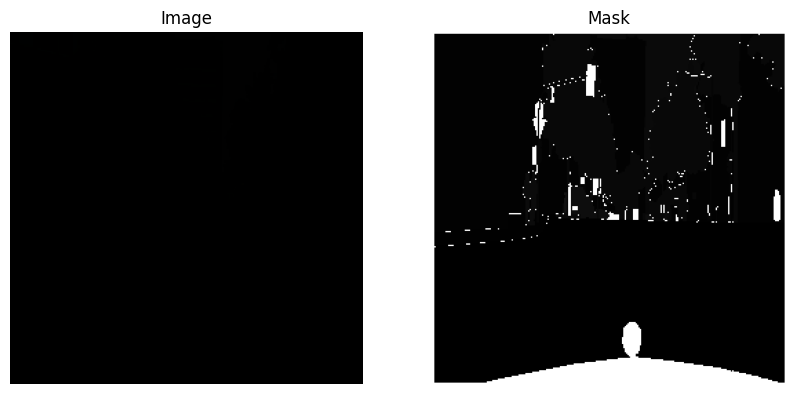

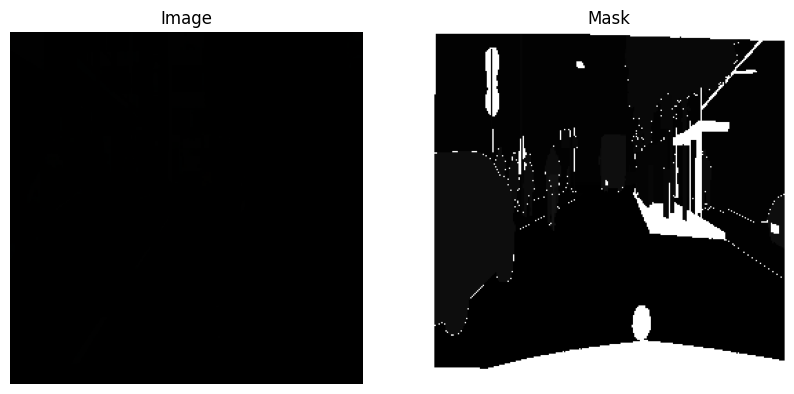

In [24]:
def visualize_from_dataloader(data_loader):
    """Visualize an image and its corresponding mask from the DataLoader."""
    # Get one batch of data
    images, masks = next(iter(data_loader))
    
    # Select the first image and mask from the batch
    image = images[0]  # Shape: (C, H, W)
    mask = masks[0]    # Shape: (C, H, W) or (H, W)
    
    # Convert image and mask for visualization
    image = image.numpy().transpose(1, 2, 0)  # (C, H, W) to (H, W, C)
    mask = mask.numpy().squeeze()  # Remove channel dimension if needed

    # Create a figure with 2 subplots
    plt.figure(figsize=(10, 5))
    
    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')  # Hide axes
    
    # Display the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')  # Use cmap='gray' for grayscale
    plt.title('Mask')
    plt.axis('off')  # Hide axes

    plt.show()

# Call the function to visualize
visualize_from_dataloader(train_loader)
visualize_from_dataloader(val_loader)

Training

In [25]:
print(torch.cuda.is_available())

torch.cuda.get_device_name(0)

True


'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

In [26]:
print(images.shape)

torch.Size([16, 3, 256, 256])


In [27]:
print(masks.shape)

torch.Size([16, 256, 256])


In [28]:
print("Unique mask values:", masks.unique())


Unique mask values: tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18, 255])


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

In [35]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_classes=20):
        super(UNet, self).__init__()
        
        # Encoder
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.decoder4 = self.upconv_block(1024, 512)
        self.decoder3 = self.upconv_block(512, 256)
        self.decoder2 = self.upconv_block(256, 128)
        self.decoder1 = self.upconv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.encoder3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.encoder4(F.max_pool2d(enc3, kernel_size=2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2))

        # Decoder
        dec4 = self.decoder4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)  # Concatenate encoder4
        dec4 = self.conv_block(1024, 512)(dec4)  # Pass through conv block after concatenation

        dec3 = self.decoder3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.conv_block(512, 256)(dec3)

        dec2 = self.decoder2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.conv_block(256, 128)(dec2)

        dec1 = self.decoder1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.conv_block(128, 64)(dec1)

        return self.final_conv(dec1)  # Output shape: [batch_size, out_classes, H, W]

In [36]:
# Number of output classes (excluding the ignore label 255)
num_classes = 19  # Adjust as needed for your classes

# Initialize the U-Net model
model = UNet(in_channels=3, out_classes=num_classes)  # Use in_channels=3 for RGB images

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=255 )  # Suitable for multi-class segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

# Example training loop (pseudocode)
num_epochs = 25  # Adjust based on your needs
for epoch in range(num_epochs):
    model.train()
    for images, masks in train_loader:  # Assuming dataloader yields (images, masks)
        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, masks)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/25, Loss: 1.9628
Epoch 2/25, Loss: 2.3543
Epoch 3/25, Loss: 1.8865
Epoch 4/25, Loss: 1.9036
Epoch 5/25, Loss: 2.4037
Epoch 6/25, Loss: 1.9543
Epoch 7/25, Loss: 1.8365
Epoch 8/25, Loss: 2.1697
Epoch 9/25, Loss: 1.7201
Epoch 10/25, Loss: 1.6956
Epoch 11/25, Loss: 1.6825
Epoch 12/25, Loss: 1.7707
Epoch 13/25, Loss: 1.5724
Epoch 14/25, Loss: 1.6702
Epoch 15/25, Loss: 1.5643
Epoch 16/25, Loss: 1.6254
Epoch 17/25, Loss: 1.5607
Epoch 18/25, Loss: 1.7195
Epoch 19/25, Loss: 1.6189
Epoch 20/25, Loss: 1.6070
Epoch 21/25, Loss: 1.6672
Epoch 22/25, Loss: 1.4628
Epoch 23/25, Loss: 1.5494
Epoch 24/25, Loss: 1.6453
Epoch 25/25, Loss: 1.5228


In [41]:
def calculate_iou(pred_mask, true_mask, num_classes):
    iou_per_class = []
    
    for class_idx in range(num_classes):
        # Get the predicted and true mask for the current class
        pred_class = (pred_mask == class_idx).float()
        true_class = (true_mask == class_idx).float()
        
        # Calculate Intersection and Union
        intersection = (pred_class * true_class).sum().item()
        union = (pred_class + true_class).sum().item() - intersection
        
        if union == 0:
            iou_per_class.append(float('nan'))  # If there's no ground truth, skip this class
        else:
            iou_per_class.append(intersection / union)
    
    # Return mean IoU over all classes
    return np.nanmean(iou_per_class)

In [42]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No gradient computation needed
    total_loss = 0
    iou_scores = []
    
    for images, masks in val_loader:  # Use the validation loader
        outputs = model(images)
        loss = criterion(outputs, masks)  # Compute loss
        total_loss += loss.item()

        # Convert model output to predicted class labels
        _, predicted = torch.max(outputs, dim=1)

        # IoU calculation (Intersection over Union)
        for pred, true in zip(predicted, masks):
            iou = calculate_iou(pred, true, num_classes)  # Custom IoU function
            iou_scores.append(iou)

    avg_loss = total_loss / len(val_loader)
    avg_iou = sum(iou_scores) / len(iou_scores)

    print(f"Validation Loss: {avg_loss:.4f}, Average IoU: {avg_iou:.4f}")


Validation Loss: 1.5552, Average IoU: 0.0534


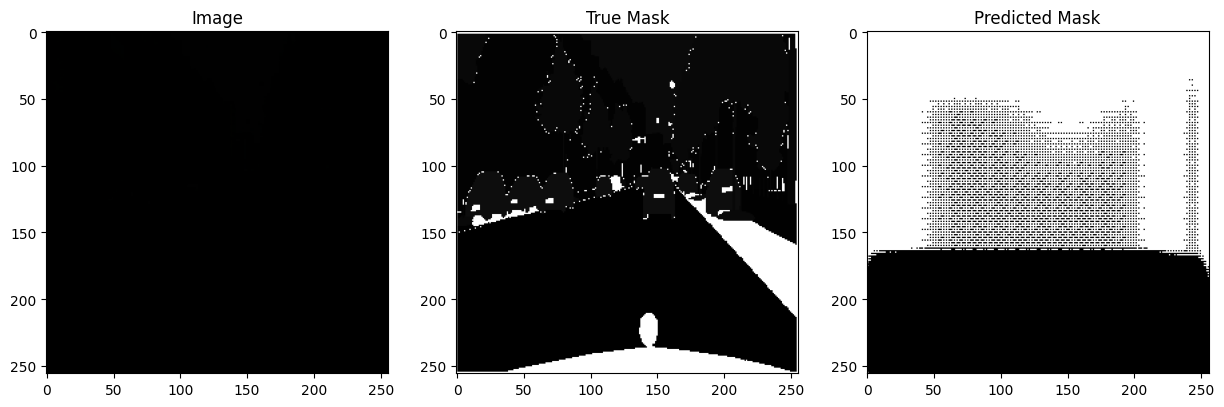

In [50]:
import matplotlib.pyplot as plt

def visualize_prediction(image, true_mask, predicted_mask):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())  # Unnormalize if needed
    plt.title("Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.cpu().numpy(), cmap="gray")
    plt.title("True Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask.cpu().numpy(), cmap="gray")
    plt.title("Predicted Mask")
    
    plt.show()

# Example usage
visualize_prediction(images[1], masks[1], predicted[1])
